In [1]:
!mv /Users/camerondavidson-pilon/Downloads/*.dump.gz ..

(B

In [2]:
!gzip -f -d ../*.dump.gz

(B

(B(B(B

In [31]:
df = pd.read_csv("../export_od_readings_raw.csv.dump")
io_events = pd.read_csv("../export_io_events.csv.dump")

In [32]:
unit = 1
start_time = "2020-10-14"

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index("timestamp")

io_events['timestamp'] = pd.to_datetime(io_events['timestamp'])
io_events = io_events.set_index("timestamp")

df= df.loc[df['morbidostat_unit'] == unit]
io_events = io_events.loc[io_events['morbidostat_unit'] == unit]

df = df.loc[start_time:]
io_events = io_events.loc[start_time:]

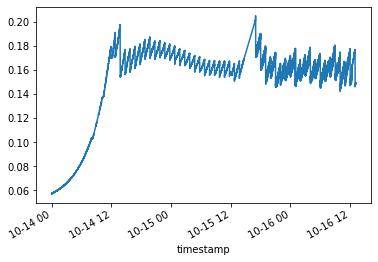

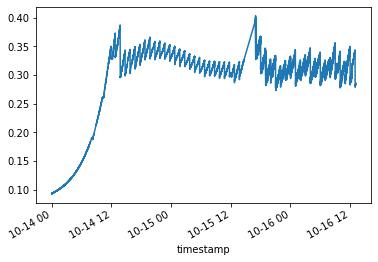

In [33]:
for _, g in df.loc["2020-09-18 9:00:00":].groupby("angle")['od_reading_v']:
    plt.figure()
    g.plot()

In [34]:
df.index = df.index.round('S')

In [35]:
df.shape

(84820, 4)

In [36]:
df_ = df.loc[df.groupby(level=0).size() == 2]

In [37]:
df_.shape

(73320, 4)

In [38]:
from morbidostat.utils.streaming_calculations import ExtendedKalmanFilter

In [39]:
df_.head(2)

,morbidostat_unit,od_reading_v,experiment,angle
timestamp,,,,
2020-10-14 00:00:02+00:00,1,0.057205,Trial-14-d29bfbaee0dd4fb28348c8cb3532cdd0,90A
2020-10-14 00:00:02+00:00,1,0.092550,Trial-14-d29bfbaee0dd4fb28348c8cb3532cdd0,90B


In [170]:
initial_state = np.array([0.057205, 0.092550, 1.0000])
d = initial_state.shape[0]

# empirically picked constants
initial_covariance = np.diag([1e-3] * (d - 1) + [1e-8])

OD_process_covariance = 0 * np.ones((d-1, d-1))

# think of OD_process_covariance as a weighting between how much do I trust the model (lower value => rate_t = rate_{t-1}) vs how much do I trust the observations
OD_process_covariance[0, 0] = 1e-6
OD_process_covariance[1, 1] = 1e-6

# think of rate_process_variance as a weighting between how much do I trust the model (lower value => rate_t = rate_{t-1}) vs how much do I trust the observations
rate_process_variance = 1e-11
process_noise_covariance = np.block(
    [[OD_process_covariance, 0* np.ones((d - 1, 1))], [0 * np.ones((1, d - 1)), rate_process_variance]]
)
observation_noise_covariance = 1e-3 * np.eye(d - 1)
ekf = ExtendedKalmanFilter(
    initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance,
)

In [171]:
results = []
try:
    obs_and_io = df_.merge(io_events, how="outer", right_index=True, left_index=True).sort_index()
except:
    obs_and_io = df_

for _, g in obs_and_io.groupby(level=0):
    if g.shape[0] == 1:
        ekf.scale_OD_variance_for_next_n_steps(1e3, 3 * 60 * 0.2)
    elif g.shape[0] == 2:
        ekf.update(g.sort_values("angle")['od_reading_v'].values)
        results.append(ekf.state_)
    else:
        pass
        
results = pd.DataFrame(results, columns=['90A', '90B',  'rate'])

<AxesSubplot:>

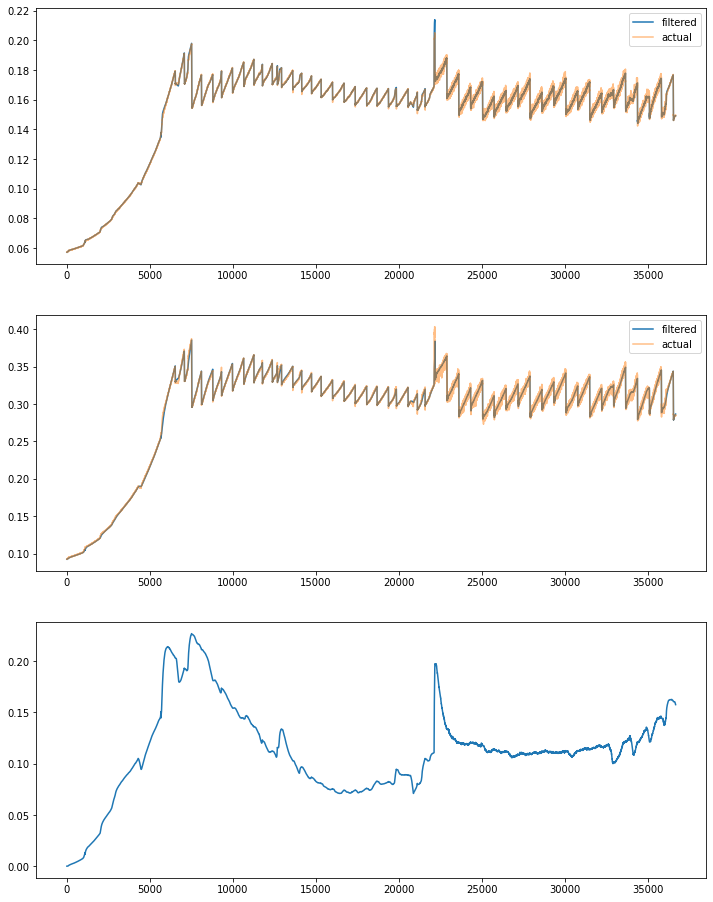

In [172]:
f, axes = plt.subplots(3, 1, figsize=(12, 16))


results['90A'].plot(label="filtered", ax=axes[0])
axes[0].plot(df_.loc[df_['angle'] == "90A"]['od_reading_v'].values, alpha=0.5, label="actual")
axes[0].legend()

results['90B'].plot(label="filtered", ax=axes[1])
axes[1].plot(df_.loc[df_['angle'] == "90B"]['od_reading_v'].values, alpha=0.5, label="actual")
axes[1].legend()

(np.log(results['rate'])*60*60*0.2).plot(ax=axes[2])


<AxesSubplot:label='ab42cd8d-78f1-4037-b834-e26cd5380c42'>

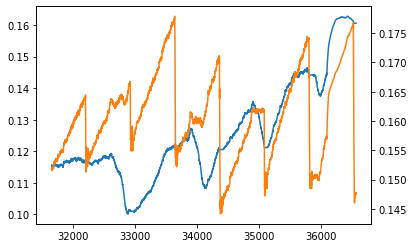

In [169]:
lb = 5000
(np.log(results['rate'])*60*60*0.2).iloc[-lb:-100].plot()
results['90A'].iloc[-lb:-100].plot(secondary_y=True)